In [1]:

import numpy as np
import pandas as pd

from collections import Counter
from seaborn import heatmap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import spacy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
import re

In [112]:
nlp = spacy.load('en_core_web_sm')

In [4]:

df = pd.read_csv("https://query.data.world/s/nrbtbcd7jydlrybusl7mom5rvov4zd",
                 encoding = "ISO-8859-1")

df.to_csv("../data/twitter_dataset.csv")

function that removes non ascii characters based on  https://stackoverflow.com/questions/26541968/delete-every-non-utf-8-symbols-from-string

In [6]:
def file_to_ascii(filename, writename = None):
    """rewrites a file with only ascii. returns None unless there's an error"""
    if writename is None:
        writename = filename[:-4] + "_only_ascii.csv"
    cleaned_doc = []
    with open(filename, "r") as readfile:
        for line in readfile:
            line = str(line.strip())
            cleaned_doc.append(line.encode("ascii", "ignore"))

    try:
        with open(writename, "xb") as writefile:
            for i in cleaned_doc:
                writefile.write(i + b"\n")
    except BaseException as e:
        print(e)
        return e
    
    return None

In [7]:
file_to_ascii("../data/twitter_dataset.csv")

[Errno 17] File exists: '../data/twitter_dataset_only_ascii.csv'


FileExistsError(17, 'File exists')

In [3]:
df = pd.read_csv("../data/twitter_dataset_only_ascii.csv").drop(["Unnamed: 0"], axis = 1)

In [23]:
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


## Data Cleaning

In [4]:
df.columns = ['text', 'directed_at', 'emotion']

In [5]:
df.text.isnull().any()

True

In [6]:
df.drop(index=6, inplace=True)

In [7]:
df.text.isnull().any()

False

In [8]:
df.reset_index(inplace=True)

In [36]:
df.emotion.unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [37]:
df.emotion.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [38]:
df.directed_at.unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

#### Modifying Target Class

In [9]:
conditions = [(df.emotion=='No emotion toward brand or product'),
  (df.emotion=='Positive emotion'),
  (df.emotion=='Negative emotion'),
  (df.emotion=="I can't tell")]
cases=[0, 2, 1, 3]
df['target']= np.select(conditions, cases) 

In [29]:
df.target.value_counts(normalize=True)

0    0.592609
2    0.327541
1    0.062692
3    0.017158
Name: target, dtype: float64

#### Grouping directed_at by brand

In [11]:

apple= ['iPhone', 'iPad or iPhone App', 'iPad', 'Apple', 'Other Apple product or service']
google = ['Google', 'Android', 'Android App', 'Other Google product or service']
conditions = [
    (df.directed_at == 'iPhone')|(df.directed_at == 'iPad or iPhone App')|
    (df.directed_at == 'iPad')|(df.directed_at == 'Apple')|(df.directed_at == 'Other Apple product or service'),
    (df.directed_at == 'Google')|(df.directed_at == 'Android')|
    (df.directed_at == 'Android App')|(df.directed_at == 'Other Google product or service')]
cases=['Apple', 'Google']
df['brand']=np.select(conditions, cases, None)

In [43]:
df.target.value_counts()

0    5389
2    2978
1     570
3     156
Name: target, dtype: int64

In [44]:
df.drop(index=df[df.target>2].index, inplace=True)
df.target.value_counts()

0    5389
2    2978
1     570
Name: target, dtype: int64

In [45]:
df.reset_index(inplace=True)

## Tokenization — spacy remove stopwords and lemmatization
based on https://nbviewer.jupyter.org/github/matt8955/tweet-explorer/blob/master/flatiron_tweets.ipynb

In [116]:
def check_stop_punct(token):
    if token.is_stop or token.is_punct:
        return False
    else:
        return True

In [114]:
def clean_doc_lem_stop(document):
    no_stop_li = list(filter(check_stop_punct, document))
    lemma_li = list(map(lambda x: x.lemma_, no_stop_li))
    return " ".join(lemma_li)


In [48]:
def remove_stop_lemmatize(text_series):
    """accepts a pandas series of strings and returns a lemmatized version
    that also drops stopwords.
    """
    doc_series = text_series.apply(nlp)
    # stopless is a list
    cleaned_series = doc_series.apply(clean_doc_lem_stop)
    return cleaned_series

In [53]:
df['doc']= remove_stop_lemmatize(df.text)

In [ ]:
df.to_csv('../data/final.csv')

## Frequency Visualizations

In [156]:
docs = list(nlp.pipe(df.text))


In [151]:
pos_docs = list(nlp.pipe(df[df.target==2].text))
neg_docs = list(nlp.pipe(df[df.target==1].text))

In [165]:


# all tokens that arent stop words or punctuations
pos_words = [token for doc in pos_docs for token in doc if token.is_stop != True and token.is_punct != True]

# noun tokens that arent stop words or punctuations
pos_nouns = [token for doc in pos_docs for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]



In [210]:
neg_words = [token for doc in neg_docs for token in doc if token.is_stop != True and token.is_punct != True]
neg_nouns= [token for doc in neg_docs for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]

In [211]:
pos_word_text=[token.lower_ for token in pos_words]
pos_noun_text=[token.lower_ for token in pos_nouns]

In [212]:
neg_word_text=[token.lower_ for token in neg_words]
neg_noun_text=[token.lower_ for token in neg_nouns]

In [213]:
# five most positivee common tokens
pos_word_freq = Counter(pos_word_text)
pos_common_words = pos_word_freq.most_common(1000)

# five most common positive noun tokens
pos_noun_freq = Counter(pos_noun_text)
pos_common_nouns = pos_noun_freq.most_common(1000)

print(pos_common_words, pos_common_nouns)

[('sxsw', 3112), ('@mention', 2155), ('link', 1208), ('ipad', 1010), ('rt', 923), ('apple', 885), ('google', 705), ('store', 546), ('iphone', 540), (' ', 495), ('2', 488), ('app', 395), ('new', 360), ('austin', 295), ('ipad2', 211), ('pop', 206), ('android', 204), ('amp', 181), ('launch', 160), ('great', 136), ('line', 132), ('party', 130), ('time', 128), ('free', 125), ('social', 124), ('cool', 118), ('like', 114), ('today', 114), ('circles', 112), ('maps', 106), ('day', 105), ('mobile', 100), ('sxswi', 97), ('awesome', 93), ('good', 92), ('love', 92), ('got', 90), ('temporary', 89), ('downtown', 88), ('opening', 88), ('network', 88), ('check', 85), ('apps', 83), ('people', 81), ('w/', 79), ('popup', 75), ('thanks', 70), ('open', 68), ('going', 67), ('mayer', 66), ('called', 64), ('best', 61), ('need', 60), ('wins', 59), ('major', 59), ('win', 58), ('want', 58), ('marissa', 57), ('video', 57), ('use', 55), ('come', 54), ('users', 53), ('nice', 52), ('tech', 51), ('4', 51), ('fun', 51)

In [214]:
# five most negative common tokens
neg_word_freq = Counter(neg_word_text)
neg_common_words = neg_word_freq.most_common(1000)

# five most common negative noun tokens
neg_noun_freq = Counter(neg_noun_text)
neg_common_nouns = neg_noun_freq.most_common(1000)



[('sxsw', 581), ('@mention', 304), ('ipad', 192), ('iphone', 163), ('google', 144), ('rt', 138), ('apple', 112), ('link', 101), (' ', 76), ('2', 63), ('app', 60), ('store', 46), ('new', 43), ('like', 39), ('circles', 33), ('social', 30), ('apps', 30), ('design', 29), ('people', 29), ('austin', 26), ('need', 25), ('android', 24), ('launch', 21), ('line', 18), ('news', 18), ('today', 18), ('time', 18), ('think', 18), ('fail', 18), ('pop', 17), ('long', 17), ('says', 16), ('battery', 16), ('users', 15), ('headaches', 15), ('day', 15), ('good', 15), ('amp', 14), ('money', 14), ('major', 14), ('network', 14), ('fascist', 14), ('company', 14), ('going', 13), ('mobile', 13), ('ipad2', 13), ('called', 13), ('phone', 13), ('way', 13), ('room', 13), ('1', 12), ('wait', 12), ('fast', 12), ('thing', 12), ('sxswi', 12), ('tapworthy', 12), ('talk', 12), ('looks', 12), ('3', 11), ('year', 11), ('$', 11), ('quot;i', 11), ('japan', 11), ('bing', 11), ('twitter', 11), ('instead', 11), ('coming', 10), ('

#### Word Frequency for Further EDA

In [274]:
neg_dict= {word:count2 for word, count2 in neg_common_words}

In [349]:
mega_common_words=[(term, (count1/len(pos_word_text)*100), (neg_dict[term]/len(neg_word_text)*100)) for term, count1 in pos_common_words if term in neg_dict.keys() and term !=' ']

In [299]:
mega_common_words

[('sxsw', 1.09930480981179, 1.1064137720901888),
 ('@mention', 0.7612473859718533, 0.578915295551493),
 ('link', 0.4267224326004635, 0.19233698964046314),
 ('ipad', 0.3567795173232352, 0.3656307129798903),
 ('rt', 0.3260470242468773, 0.26279707495429616),
 ('apple', 0.3126236364663991, 0.21328458257160268),
 ('google', 0.24903916803255527, 0.2742230347349177),
 ('store', 0.1928728875826598, 0.08759902498476538),
 ('iphone', 0.19075340530153168, 0.310405240706886),
 ('2', 0.17238455886508788, 0.11997257769652651),
 ('app', 0.13953258350760187, 0.11425959780621572),
 ('new', 0.12716893686768777, 0.0818860450944546),
 ('austin', 0.10420787882213306, 0.04951249238269348),
 ('ipad2', 0.07453512688633923, 0.02475624619134674),
 ('pop', 0.07276889165206579, 0.03237355271176112),
 ('android', 0.07206239755835642, 0.04570383912248629),
 ('amp', 0.06393771548069858, 0.026660572821450335),
 ('launch', 0.05651952749675013, 0.039990859232175505),
 ('great', 0.04804159837223761, 0.015234613040828763

In [413]:
def text_size(total):
    return 40 + total*70

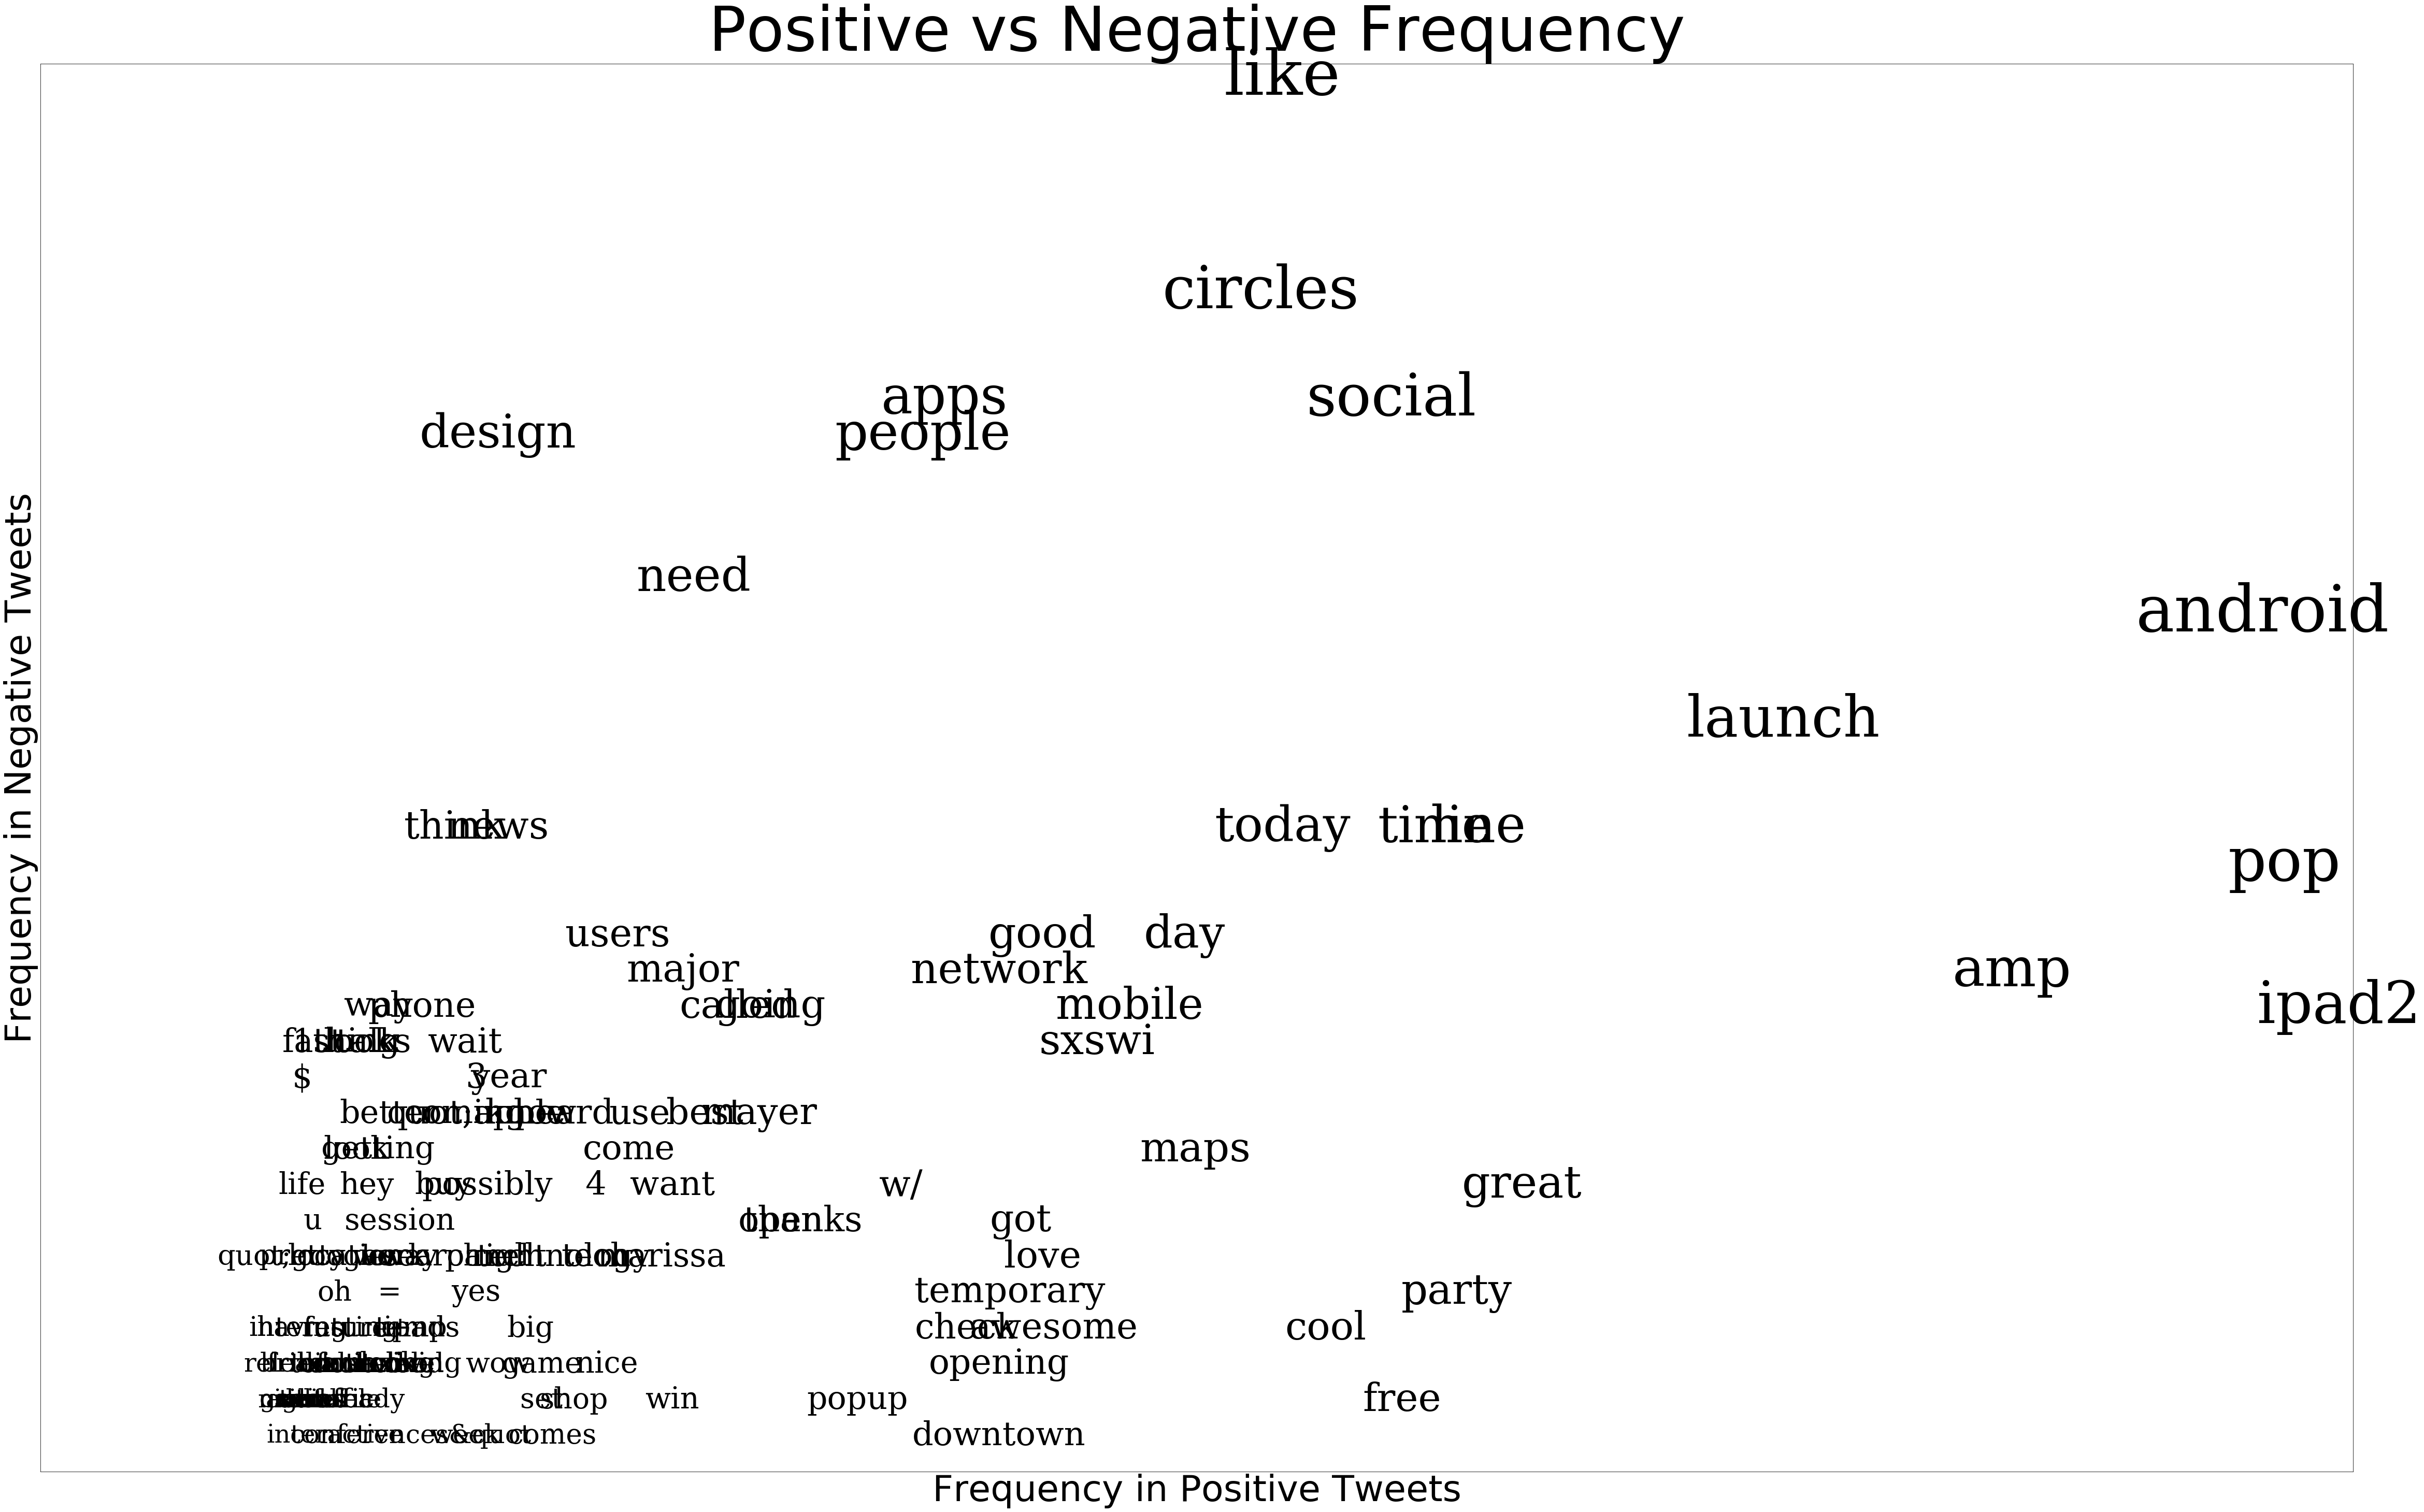

In [417]:
fig, ax= plt.subplots(figsize=(80,50))

for word, pos_pop, neg_pop in mega_common_words[13:140]:
    ax.text(pos_pop, neg_pop, word, ha='center', va='center', size=text_size(pos_pop+neg_pop), fontfamily='serif')

ax.set_xlabel('Frequency in Positive Tweets', fontsize= 70)
ax.set_ylabel('Frequency in Negative Tweets', fontsize= 70)
ax.axis([0,0.6, 0, 0.6])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Positive vs Negative Frequency', fontsize= 120)
plt.savefig("word_freq_axes.png")

### Unique Positive and Negative Words for Word Clouds

In [215]:

pos_unique_words=[(term, count) for term, count in pos_common_words if term not in [word for word, count in neg_common_words]]
pos_unique_words

[('wins', 59),
 ('video', 57),
 ('fun', 51),
 ('smart', 49),
 ('team', 45),
 ('case', 45),
 ('begins', 45),
 ('marketing', 44),
 ('music', 37),
 ('rumor', 33),
 ('giving', 32),
 ('tonight', 30),
 ('winning', 29),
 ('action', 29),
 ('hot', 29),
 ('congress', 27),
 ('attendees', 27),
 ('makes', 26),
 ('6th', 26),
 ('itunes', 26),
 ('schools', 24),
 ('won', 24),
 ('share', 24),
 ('geek', 24),
 ('hollergram', 23),
 ('art', 23),
 ('happy', 23),
 ('gets', 23),
 ('details', 23),
 ('gowalla', 22),
 ('saving', 22),
 ('route', 22),
 ('rock', 21),
 ('events', 20),
 ('sponsored', 20),
 ('experts', 20),
 ('crowd', 20),
 ('gsdm', 20),
 ('congrats', 20),
 ('choice', 20),
 ('|', 19),
 ('sweet', 19),
 ('core', 19),
 ('physical', 19),
 ('food', 18),
 ('block', 18),
 ('40', 18),
 ('street', 18),
 ('seeing', 17),
 ('bought', 17),
 ('huge', 17),
 ('saves', 17),
 ('7', 17),
 ('start', 16),
 ('holler', 16),
 ('gram', 16),
 ('hours', 16),
 ('retail', 16),
 ('center', 16),
 ('platform', 16),
 ('device', 16),
 

In [216]:
pos_unique_nouns=[(term, count) for term, count in pos_common_nouns if term not in [word for word, count in neg_common_nouns]]
pos_unique_nouns

[('fun', 30),
 ('music', 29),
 ('details', 21),
 ('events', 20),
 ('experts', 20),
 ('core', 19),
 ('congrats', 19),
 ('art', 17),
 ('block', 15),
 ('worlds', 14),
 ('share', 14),
 ('hollergram', 13),
 ('cases', 13),
 ('popup', 13),
 ('feature', 13),
 ('folks', 12),
 ('streaming', 12),
 ('home', 11),
 ('event', 11),
 ('band', 11),
 ('town', 11),
 ('envy', 11),
 ('giveaway', 11),
 ('street', 10),
 ('hands', 10),
 ('opening', 9),
 ('juice', 9),
 ('need', 9),
 ('developers', 9),
 ('engine', 9),
 ('killer', 9),
 ('fans', 8),
 ('example', 8),
 ('list', 8),
 ('word', 8),
 ('sale', 8),
 ('rock', 8),
 ('biz', 8),
 ('bankinnovation', 8),
 ('brain', 8),
 ('entry', 8),
 ('women', 8),
 ('end', 8),
 ('route', 8),
 ('stock', 7),
 ('disc', 7),
 ('privacy', 7),
 ('course', 7),
 ('tons', 7),
 ('t', 7),
 ('recommendations', 7),
 ('choice', 7),
 ('drinks', 7),
 ('hipster', 7),
 ('security', 7),
 ('girl', 7),
 ('owners', 7),
 ('cbatsxsw', 7),
 ('doodles', 7),
 ('yrs', 7),
 ('swarms', 7),
 ('chance', 6),
 

In [220]:
neg_unique_words=[(term, count) for term, count in neg_common_words if term != 'quot;i' and term not in [word for word, count in pos_common_words]]
neg_unique_words

[('headaches', 15),
 ('money', 14),
 ('fascist', 14),
 ('hate', 10),
 ('fades', 10),
 ('classiest', 9),
 ('novelty', 9),
 ('delegates', 9),
 ('lost', 8),
 ('relief', 8),
 ('wo', 8),
 ('swisher', 8),
 ('sucks', 7),
 ('uses', 7),
 ('button', 7),
 ('kara', 7),
 ('alarm', 6),
 ('stupid', 6),
 ('2.&quot', 6),
 ('tag', 6),
 ('elegant', 6),
 ('thinks', 5),
 ('caring', 5),
 ('douche', 5),
 ('weird', 5),
 ('expect', 5),
 ('run', 5),
 ('upgrade', 4),
 ('false', 4),
 ('blocks', 4),
 ('terrible', 4),
 ('bloody', 4),
 ('crowded', 4),
 ('fucking', 4),
 ('samsung', 4),
 ('jobs', 4),
 ('worst', 4),
 ('delicious', 4),
 ('fix', 4),
 ('vs.', 4),
 ('mistakes', 4),
 ('netflix', 4),
 ('autocorrect', 4),
 ('buttons', 4),
 ('walked', 4),
 ('tablets', 4),
 ('heat', 4),
 ('suns', 4),
 ('socialviewing', 4),
 ('reason', 4),
 ('cashmore', 4),
 ('silly', 4),
 ('dear', 4),
 ('half', 4),
 ('suck', 4),
 ('burn', 4),
 ('quot;there', 4),
 ('images', 4),
 ('dead', 3),
 ('sunday', 3),
 ('nowand', 3),
 ('crashes', 3),
 ('1

In [218]:
neg_unique_nouns=[(term, count) for term, count in neg_common_nouns if term not in [word for word, count in pos_common_nouns]]
neg_unique_nouns

[('fades', 10),
 ('delegates', 9),
 ('headaches', 8),
 ('alarm', 6),
 ('tag', 6),
 ('mistakes', 4),
 ('autocorrect', 4),
 ('buttons', 4),
 ('heat', 4),
 ('suns', 4),
 ('images', 4),
 ('geolocation', 3),
 ('batterykiller', 3),
 ('brick', 3),
 ('trend', 3),
 ('title', 3),
 ('psych', 3),
 ('smackdown', 3),
 ('banality', 3),
 ('douche', 3),
 ('film', 3),
 ('experiment', 3),
 ('solutions', 3),
 ('overload', 3),
 ('error', 3),
 ('improvement', 3),
 ('issues', 3),
 ('half', 3),
 ('hrs', 2),
 ('stations', 2),
 ('background', 2),
 ('patch', 2),
 ('10x', 2),
 ('process', 2),
 ('bettersearch', 2),
 ('margin', 2),
 ('cpa', 2),
 ('pen', 2),
 ('auto', 2),
 ('heck', 2),
 ('addicts', 2),
 ('opinions', 2),
 ('rule', 2),
 ('vortex', 2),
 ('smugness', 2),
 ('futuremf', 2),
 ('websites', 2),
 ('rji', 2),
 ('outlet', 2),
 ('strength', 2),
 ('disaster', 2),
 ('novelty', 2),
 ('ads', 2),
 ('planet', 2),
 ('handset', 2),
 ('failure', 2),
 ('cake', 2),
 ('fuck', 2),
 ('metaphor', 2),
 ('collection', 2),
 ('ego

### Word Cloud Visualizations

In [225]:
from wordcloud import WordCloud, STOPWORDS

In [228]:
from PIL import Image

In [246]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    

In [231]:
down_mask = np.array(Image.open('../thumbsdown.png'))
up_mask = np.array(Image.open('../thumbsup.png'))

In [249]:
pos_word_cloud= ' '.join([(term+' ')*count for term, count in pos_unique_words if 'quot' not in term])
pos_noun_cloud= ' '.join([(term+' ')*count for term, count in pos_unique_nouns if 'quot' not in term])

neg_word_cloud= ' '.join([(term+' ')*count for term, count in neg_unique_words if 'quot' not in term])
neg_noun_cloud= ' '.join([(term+' ')*count for term, count in neg_unique_nouns if 'quot' not in term])

In [240]:
pos_word_wordcloud

In [265]:
[text for text in df.text if 'delegates' in text]

['SXSW 2011: Novelty of iPad news apps fades fast among digital delegates {link} via @mention #SXSW XIPAD',
 '#SXSW 2011: Novelty of #iPad news apps fades fast among digital delegates {link}',
 '#SXSW 2011: Novelty of #iPad news apps fades fast among digital delegates {link} via @mention',
 '#SXSW 2011: Novelty of iPad news apps fades fast among digital delegates {link}',
 'Novelty of #iPad news #apps fades fast among digital delegates - Aron Pilhofer of the NYT &amp; Khoi Vinh {link}  #media #SXSW',
 'Novelty of iPad news apps fades fast among #SXSW delegates - by @mention {link}',
 'Agreed  Novelty of #iPad news #apps fades fast among digital delegates  {link}  #media #SXSW (via @mention',
 'RT @mention Agreed  Novelty of #iPad news #apps fades fast among digital delegates  {link}  #media #SXSW (via @mention',
 'RT @mention Novelty of iPad news apps fades fast among #SXSW delegates - by @mention {link}',
 'RT @mention SXSW 2011: Novelty of iPad news apps fades fast among digital dele

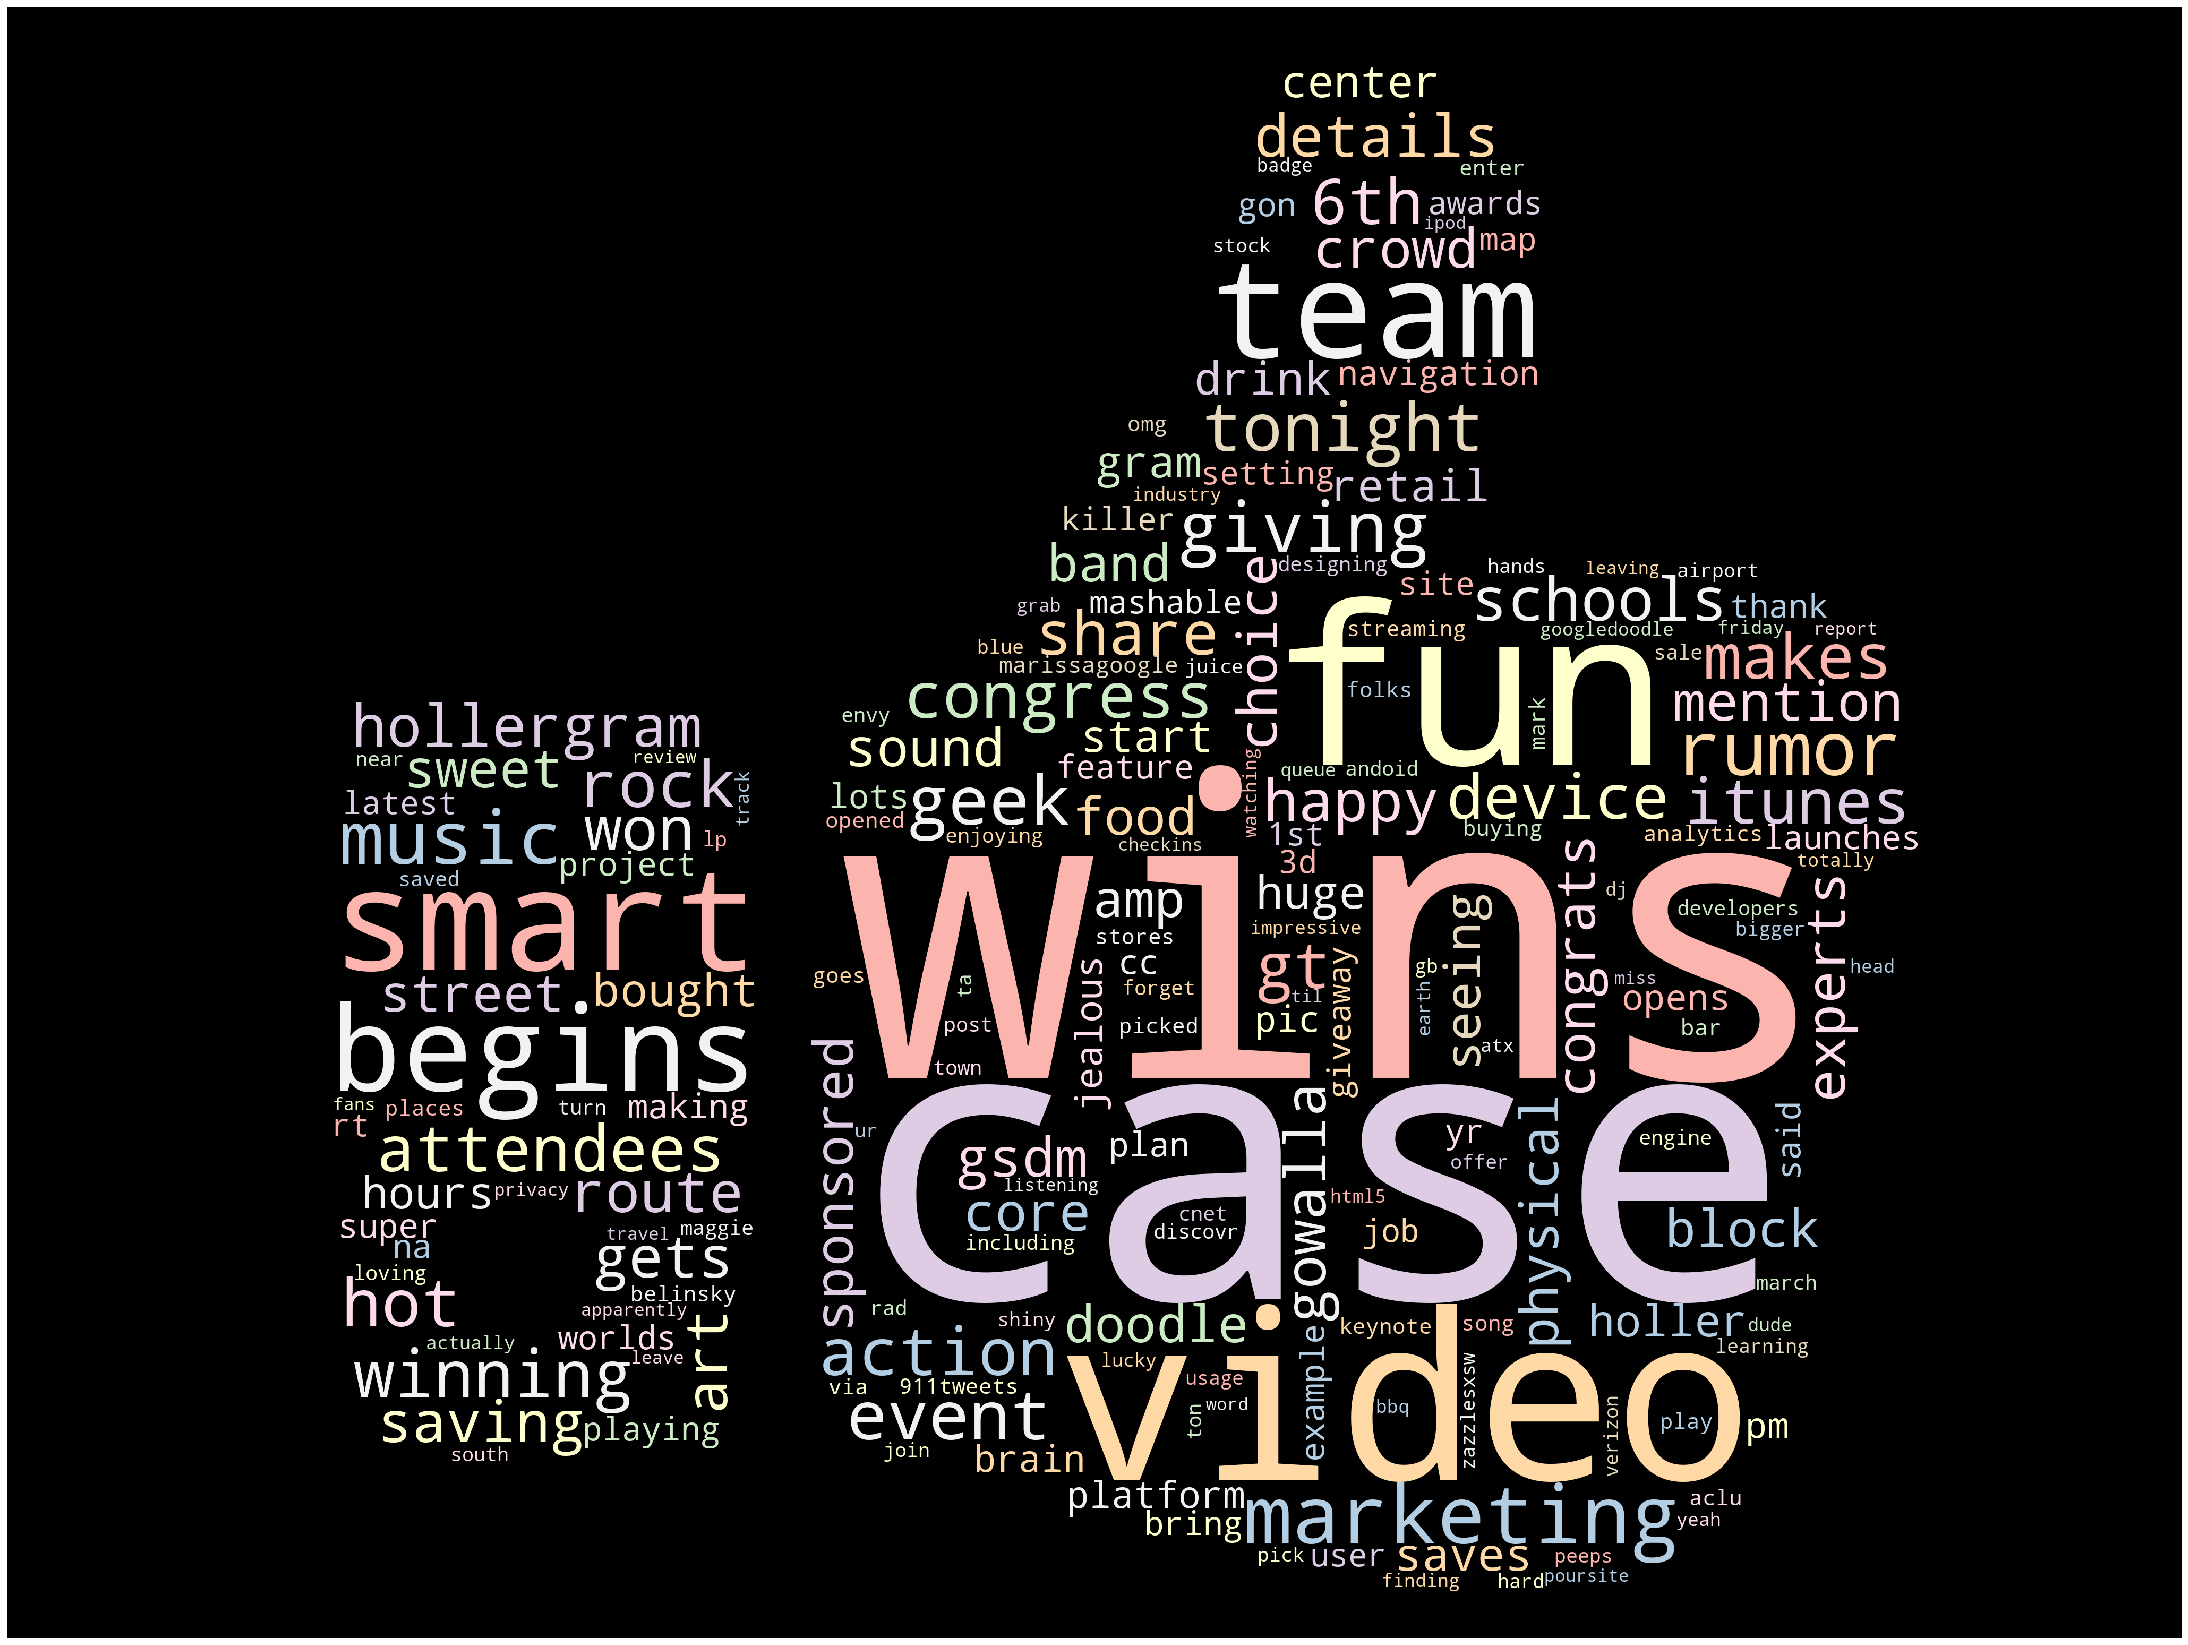

In [356]:
pos_word_wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Pastel1', collocations=False, stopwords = STOPWORDS, mask=up_mask).generate(pos_word_cloud)
plot_cloud(pos_word_wordcloud)
plt.savefig("pos_word_wordcloud.png")

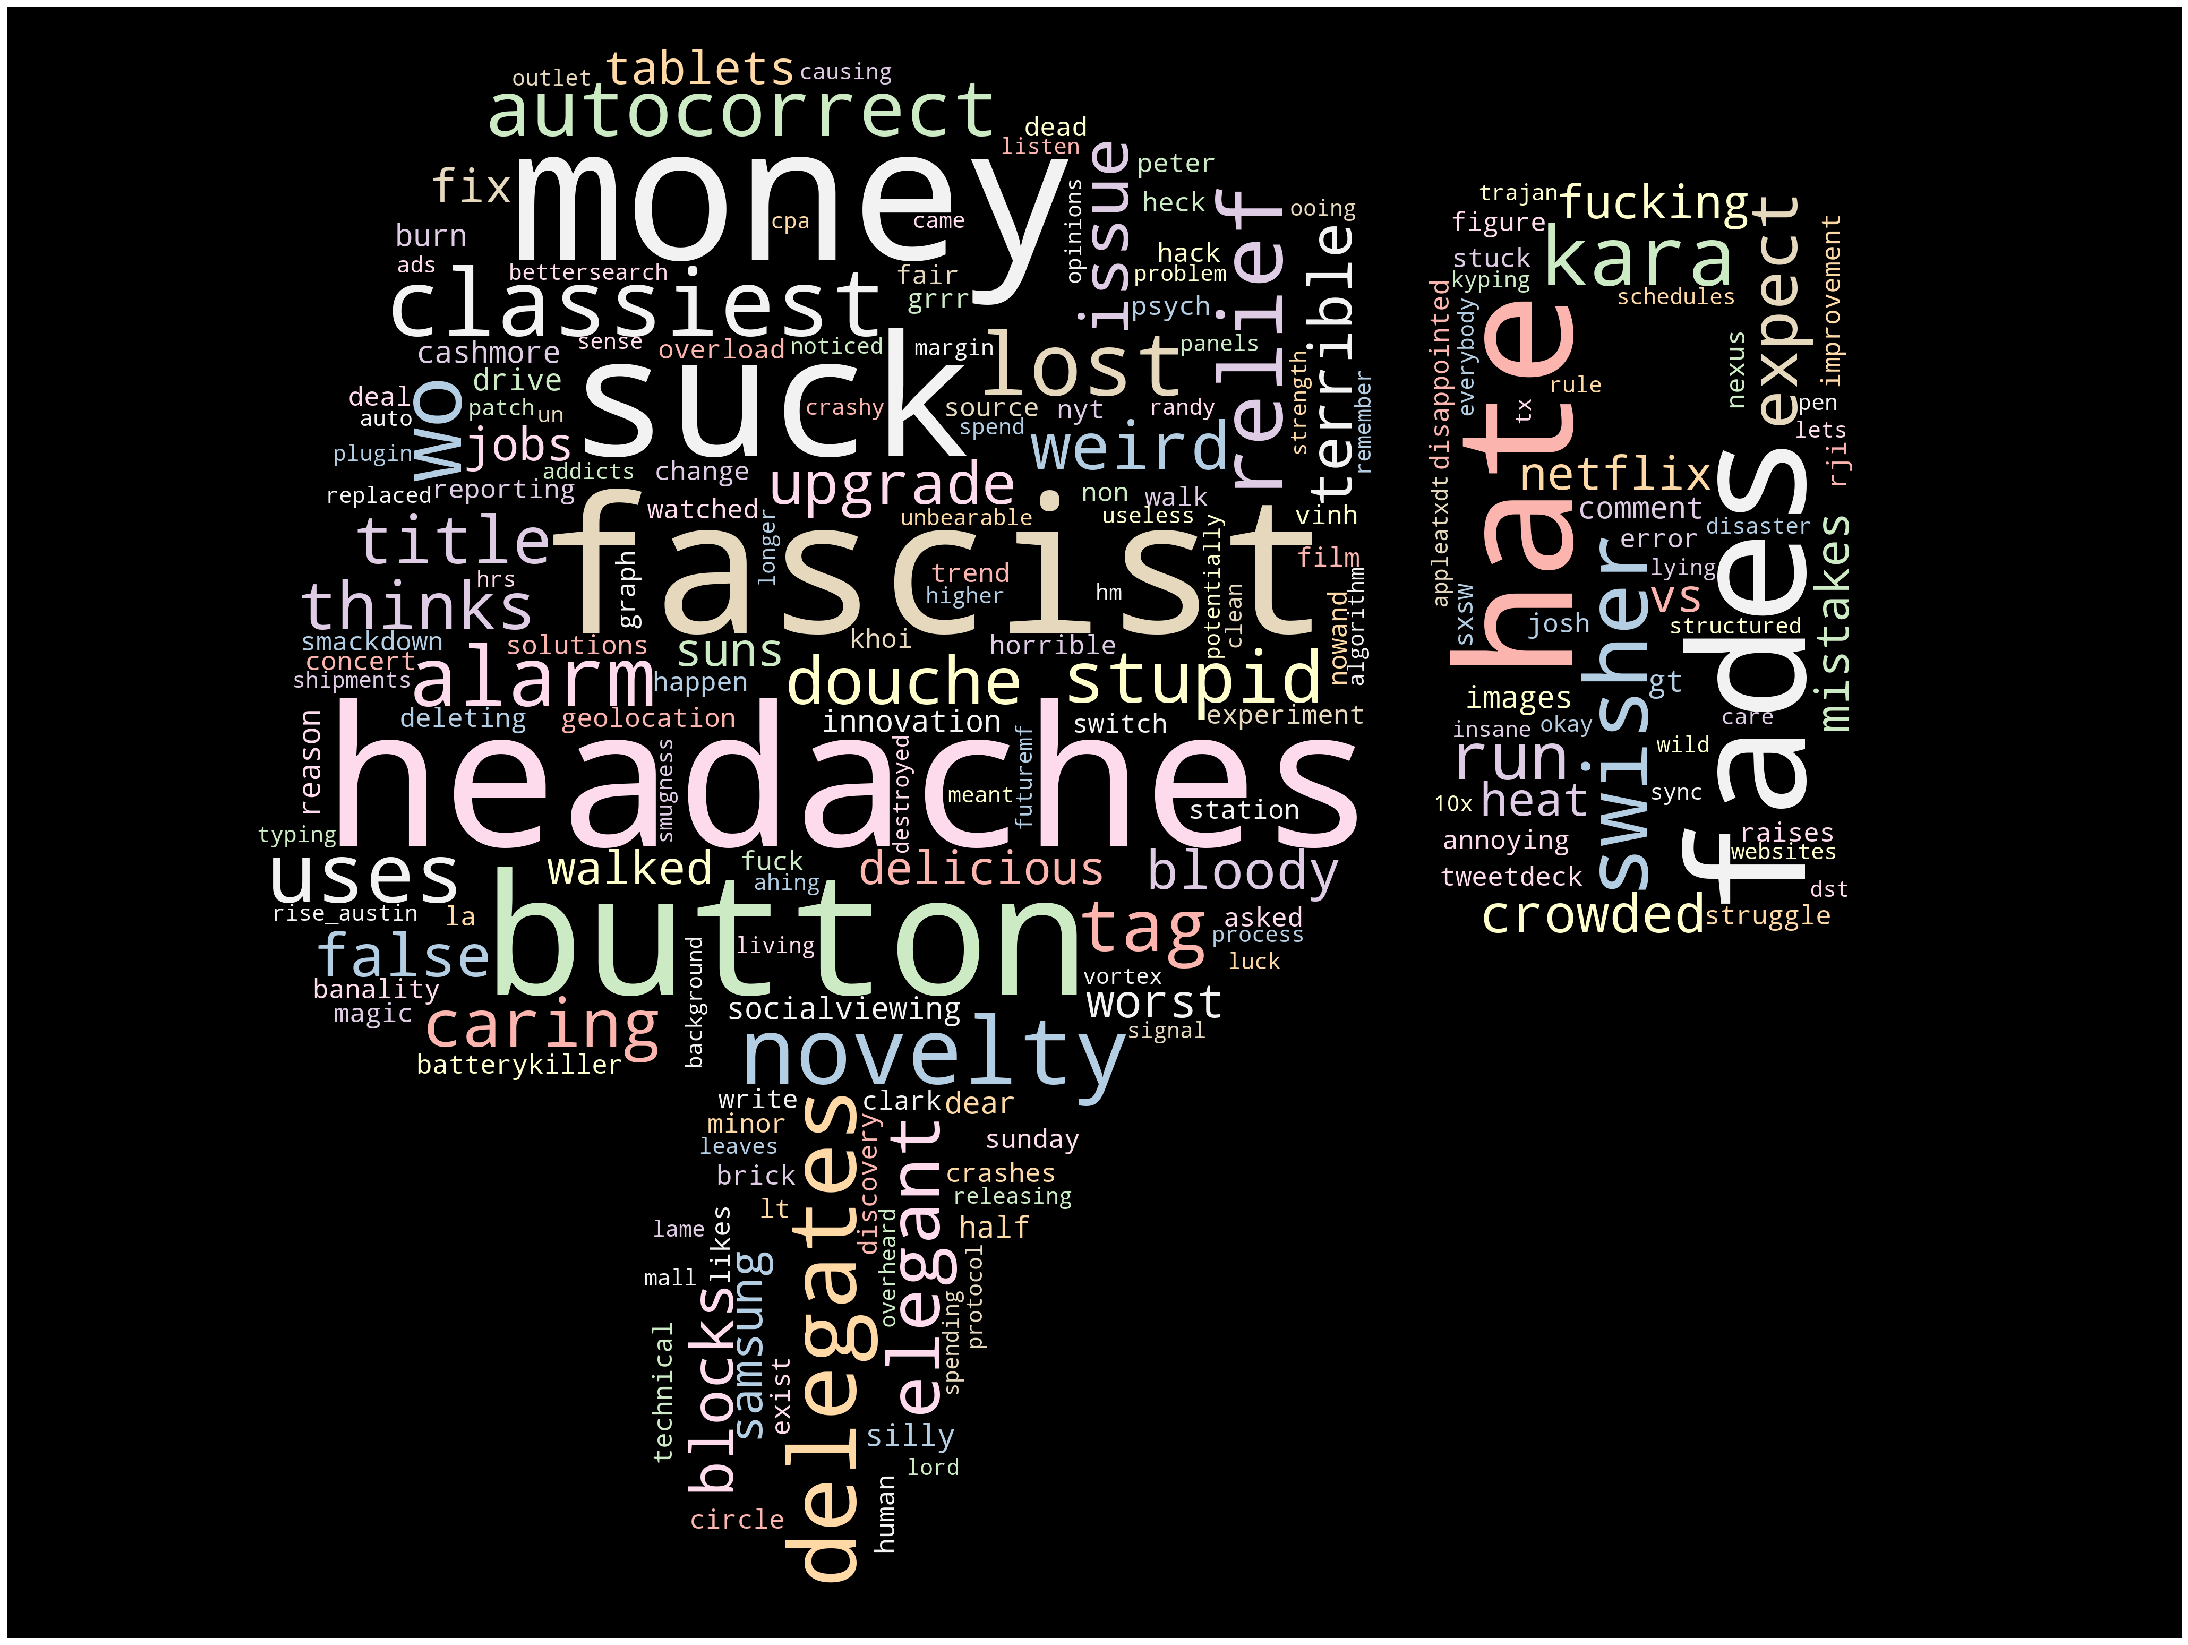

In [254]:
neg_word_wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Pastel1', collocations=False, stopwords = STOPWORDS, mask=down_mask).generate(neg_word_cloud)
plot_cloud(neg_word_wordcloud)
plt.savefig("neg_word_wordcloud.png")

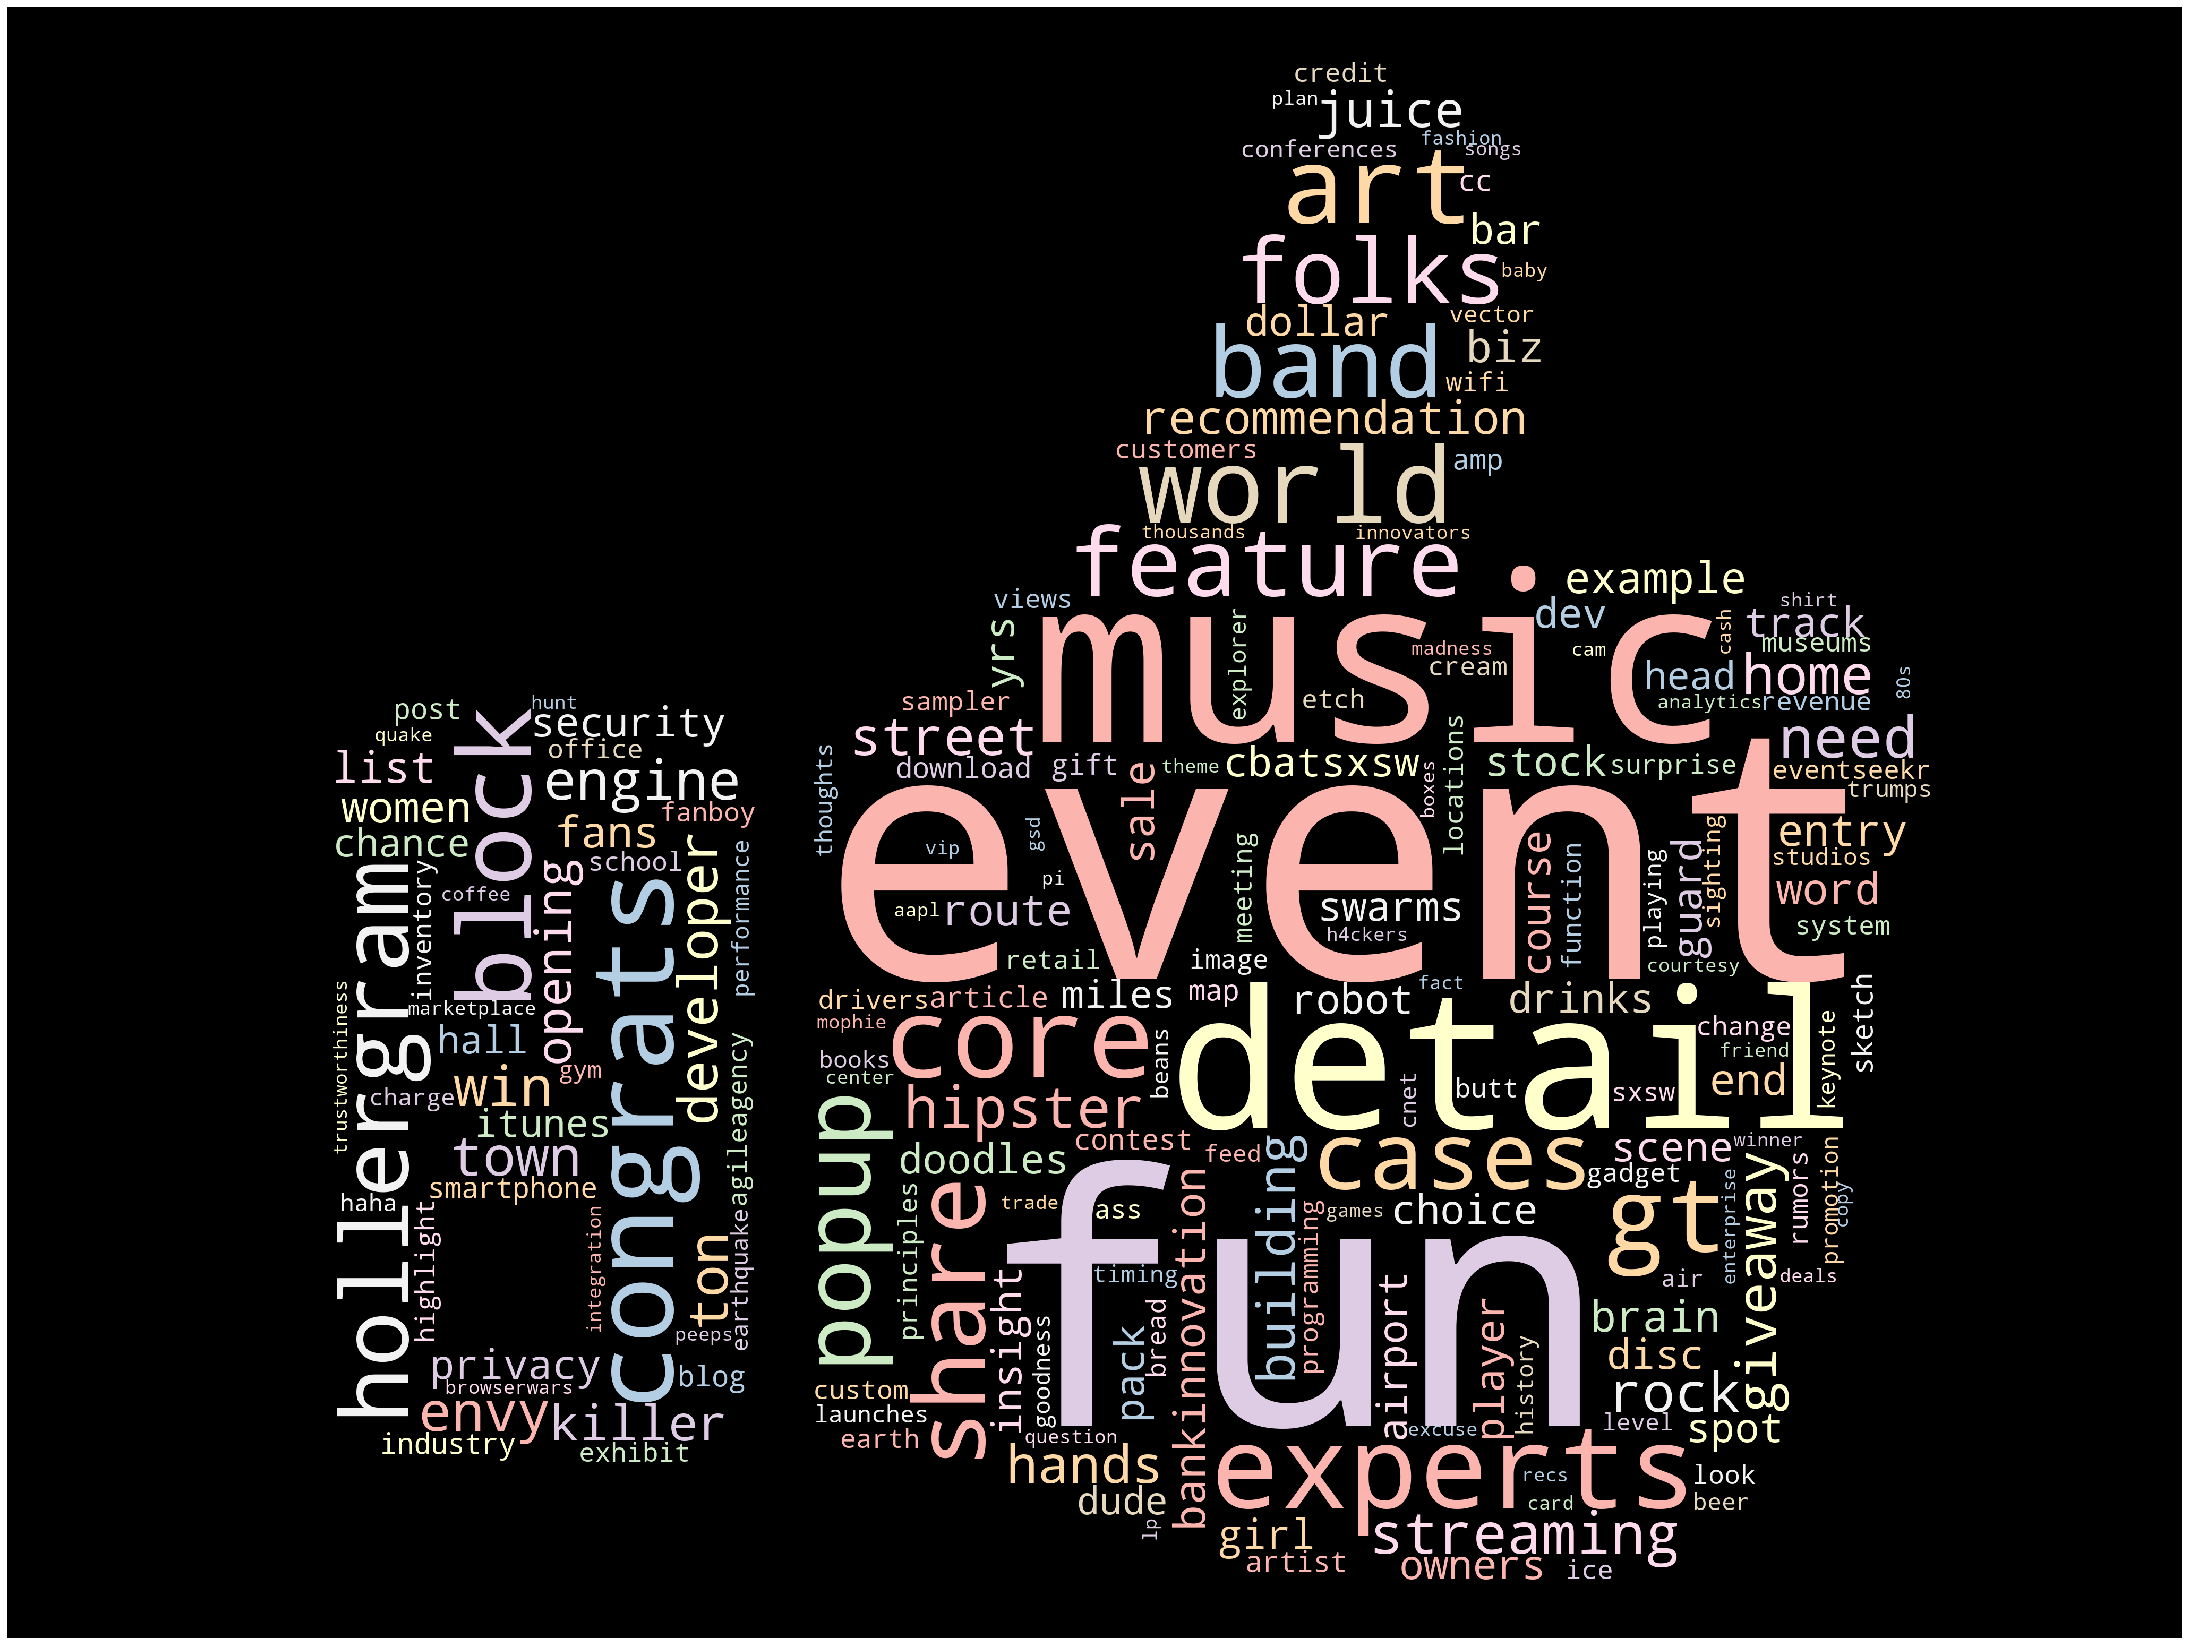

In [357]:
pos_noun_wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Pastel1', collocations=False, stopwords = STOPWORDS, mask=up_mask).generate(pos_noun_cloud)
plot_cloud(pos_noun_wordcloud)
plt.savefig("pos_noun_wordcloud.png")

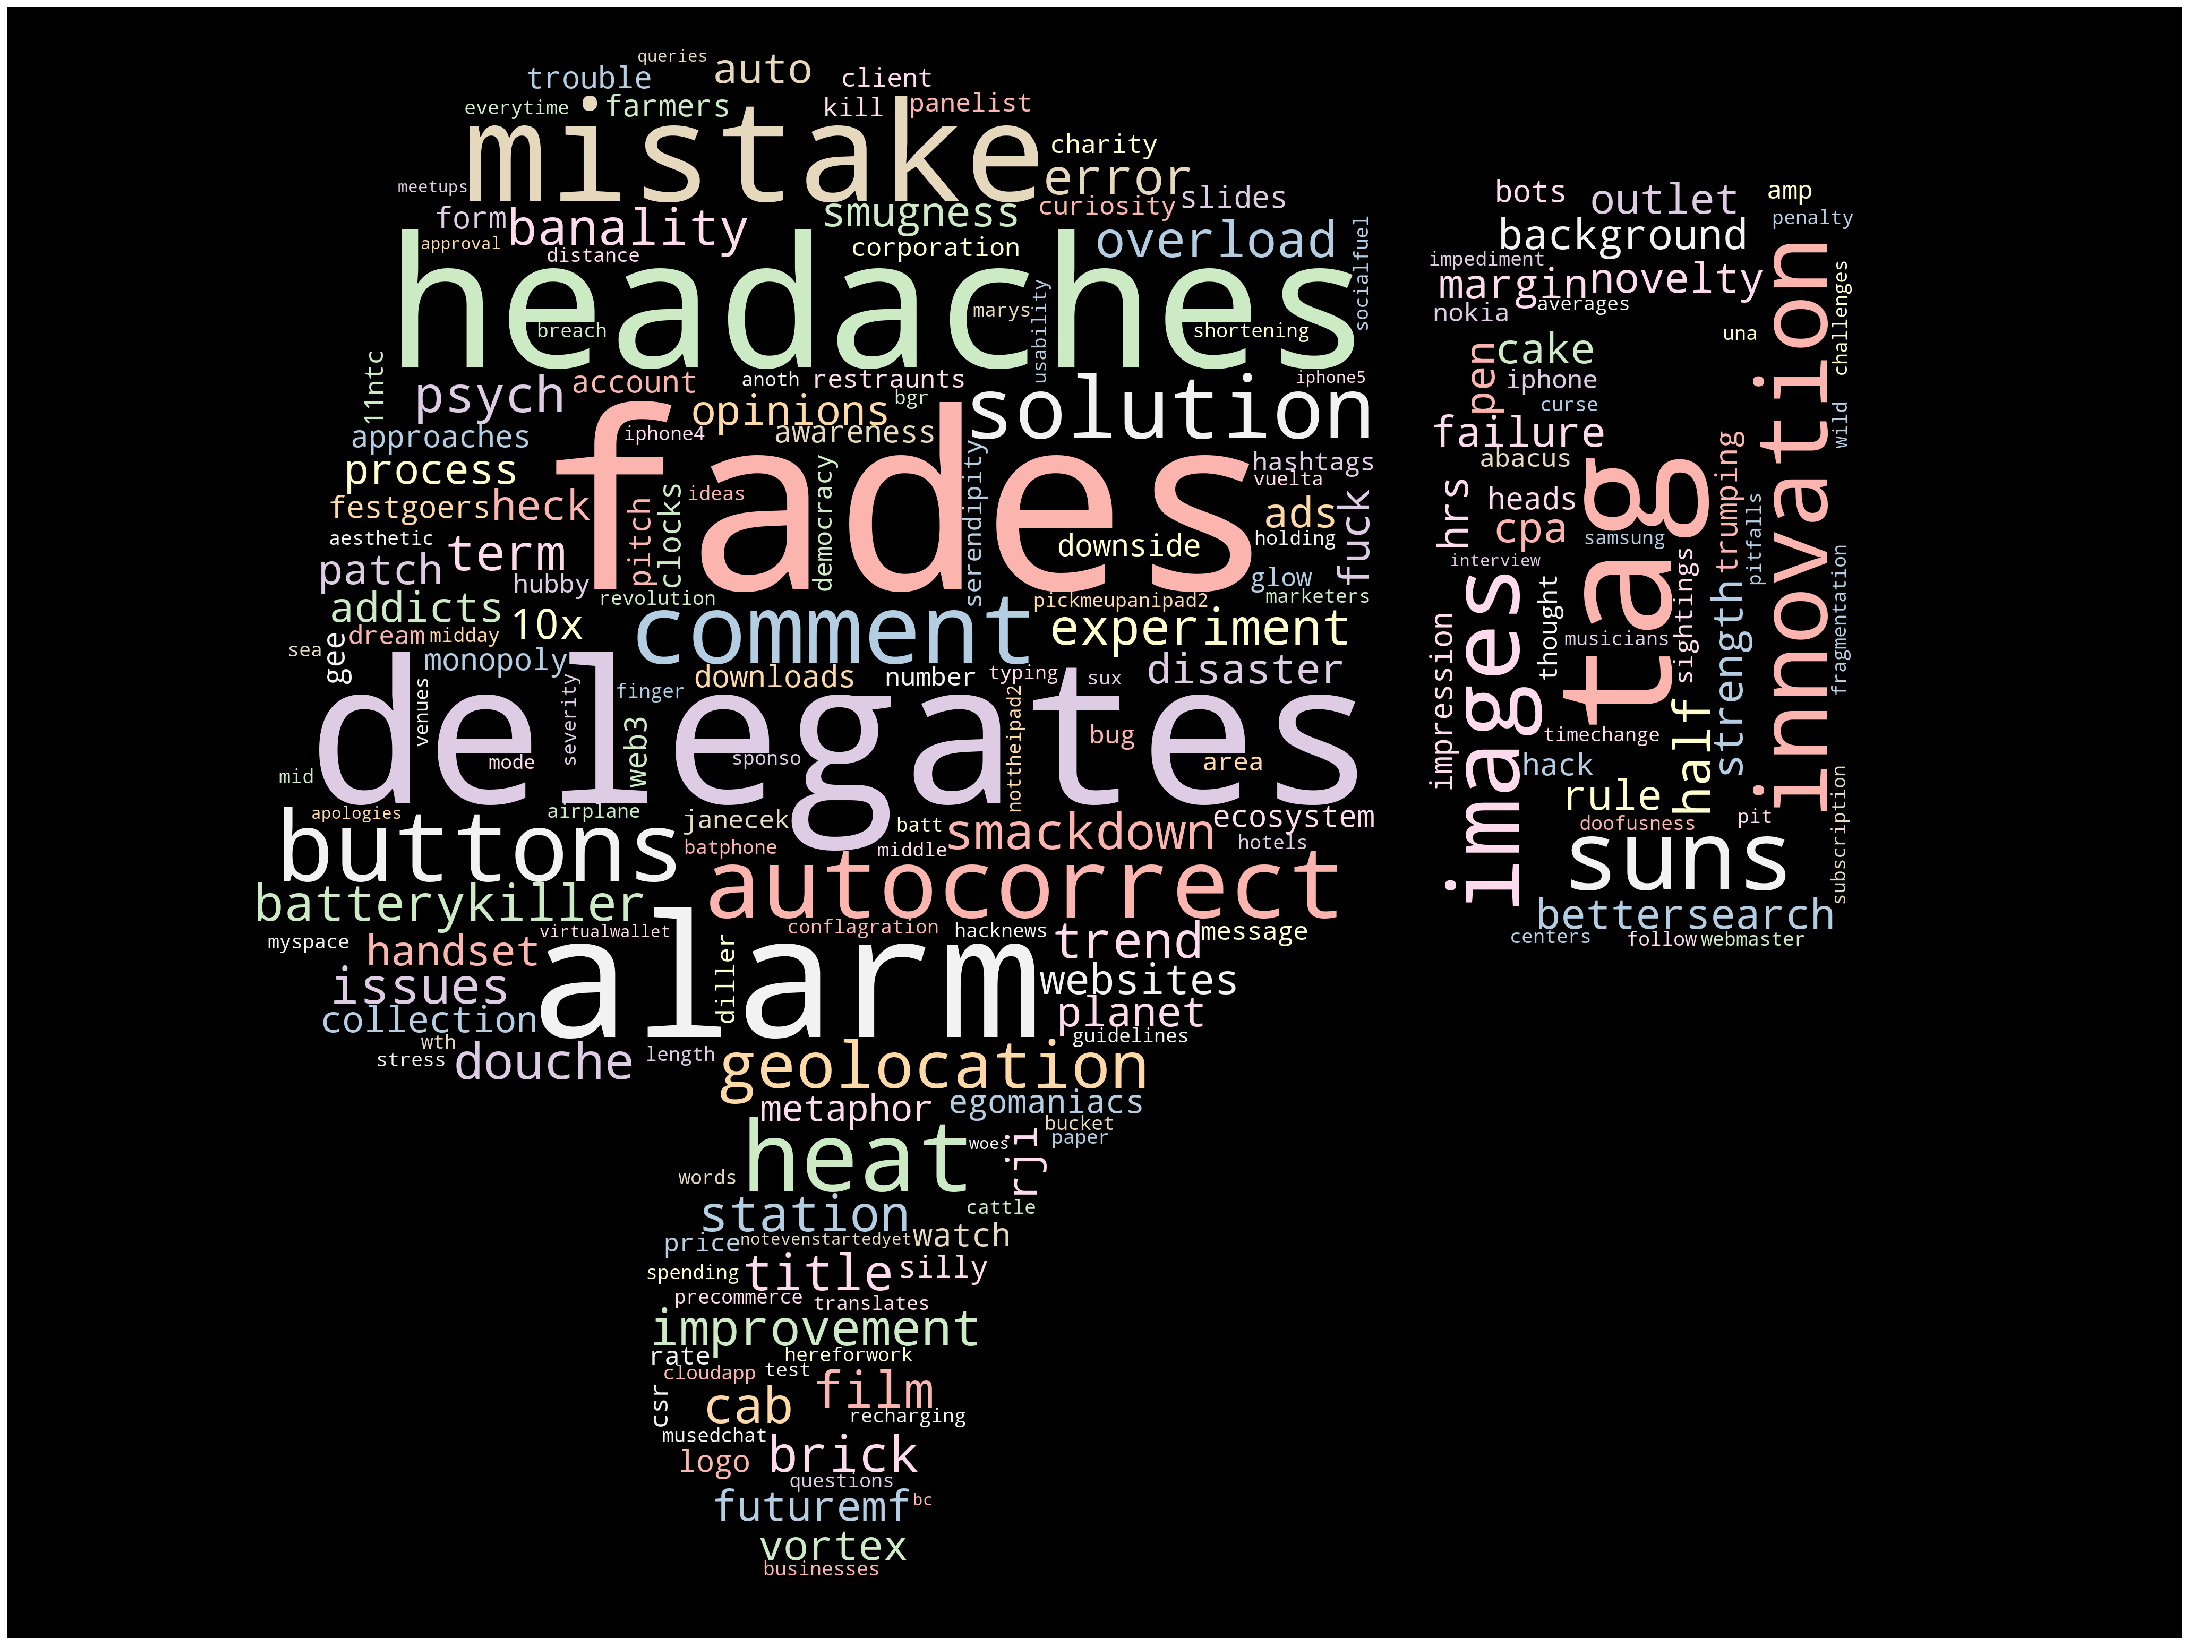

In [256]:
neg_noun_wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Pastel1', collocations=False, stopwords = STOPWORDS, mask=down_mask).generate(neg_noun_cloud)
plot_cloud(neg_noun_wordcloud)
plt.savefig("neg_noun_wordcloud.png")

## EDA-Visualizations

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

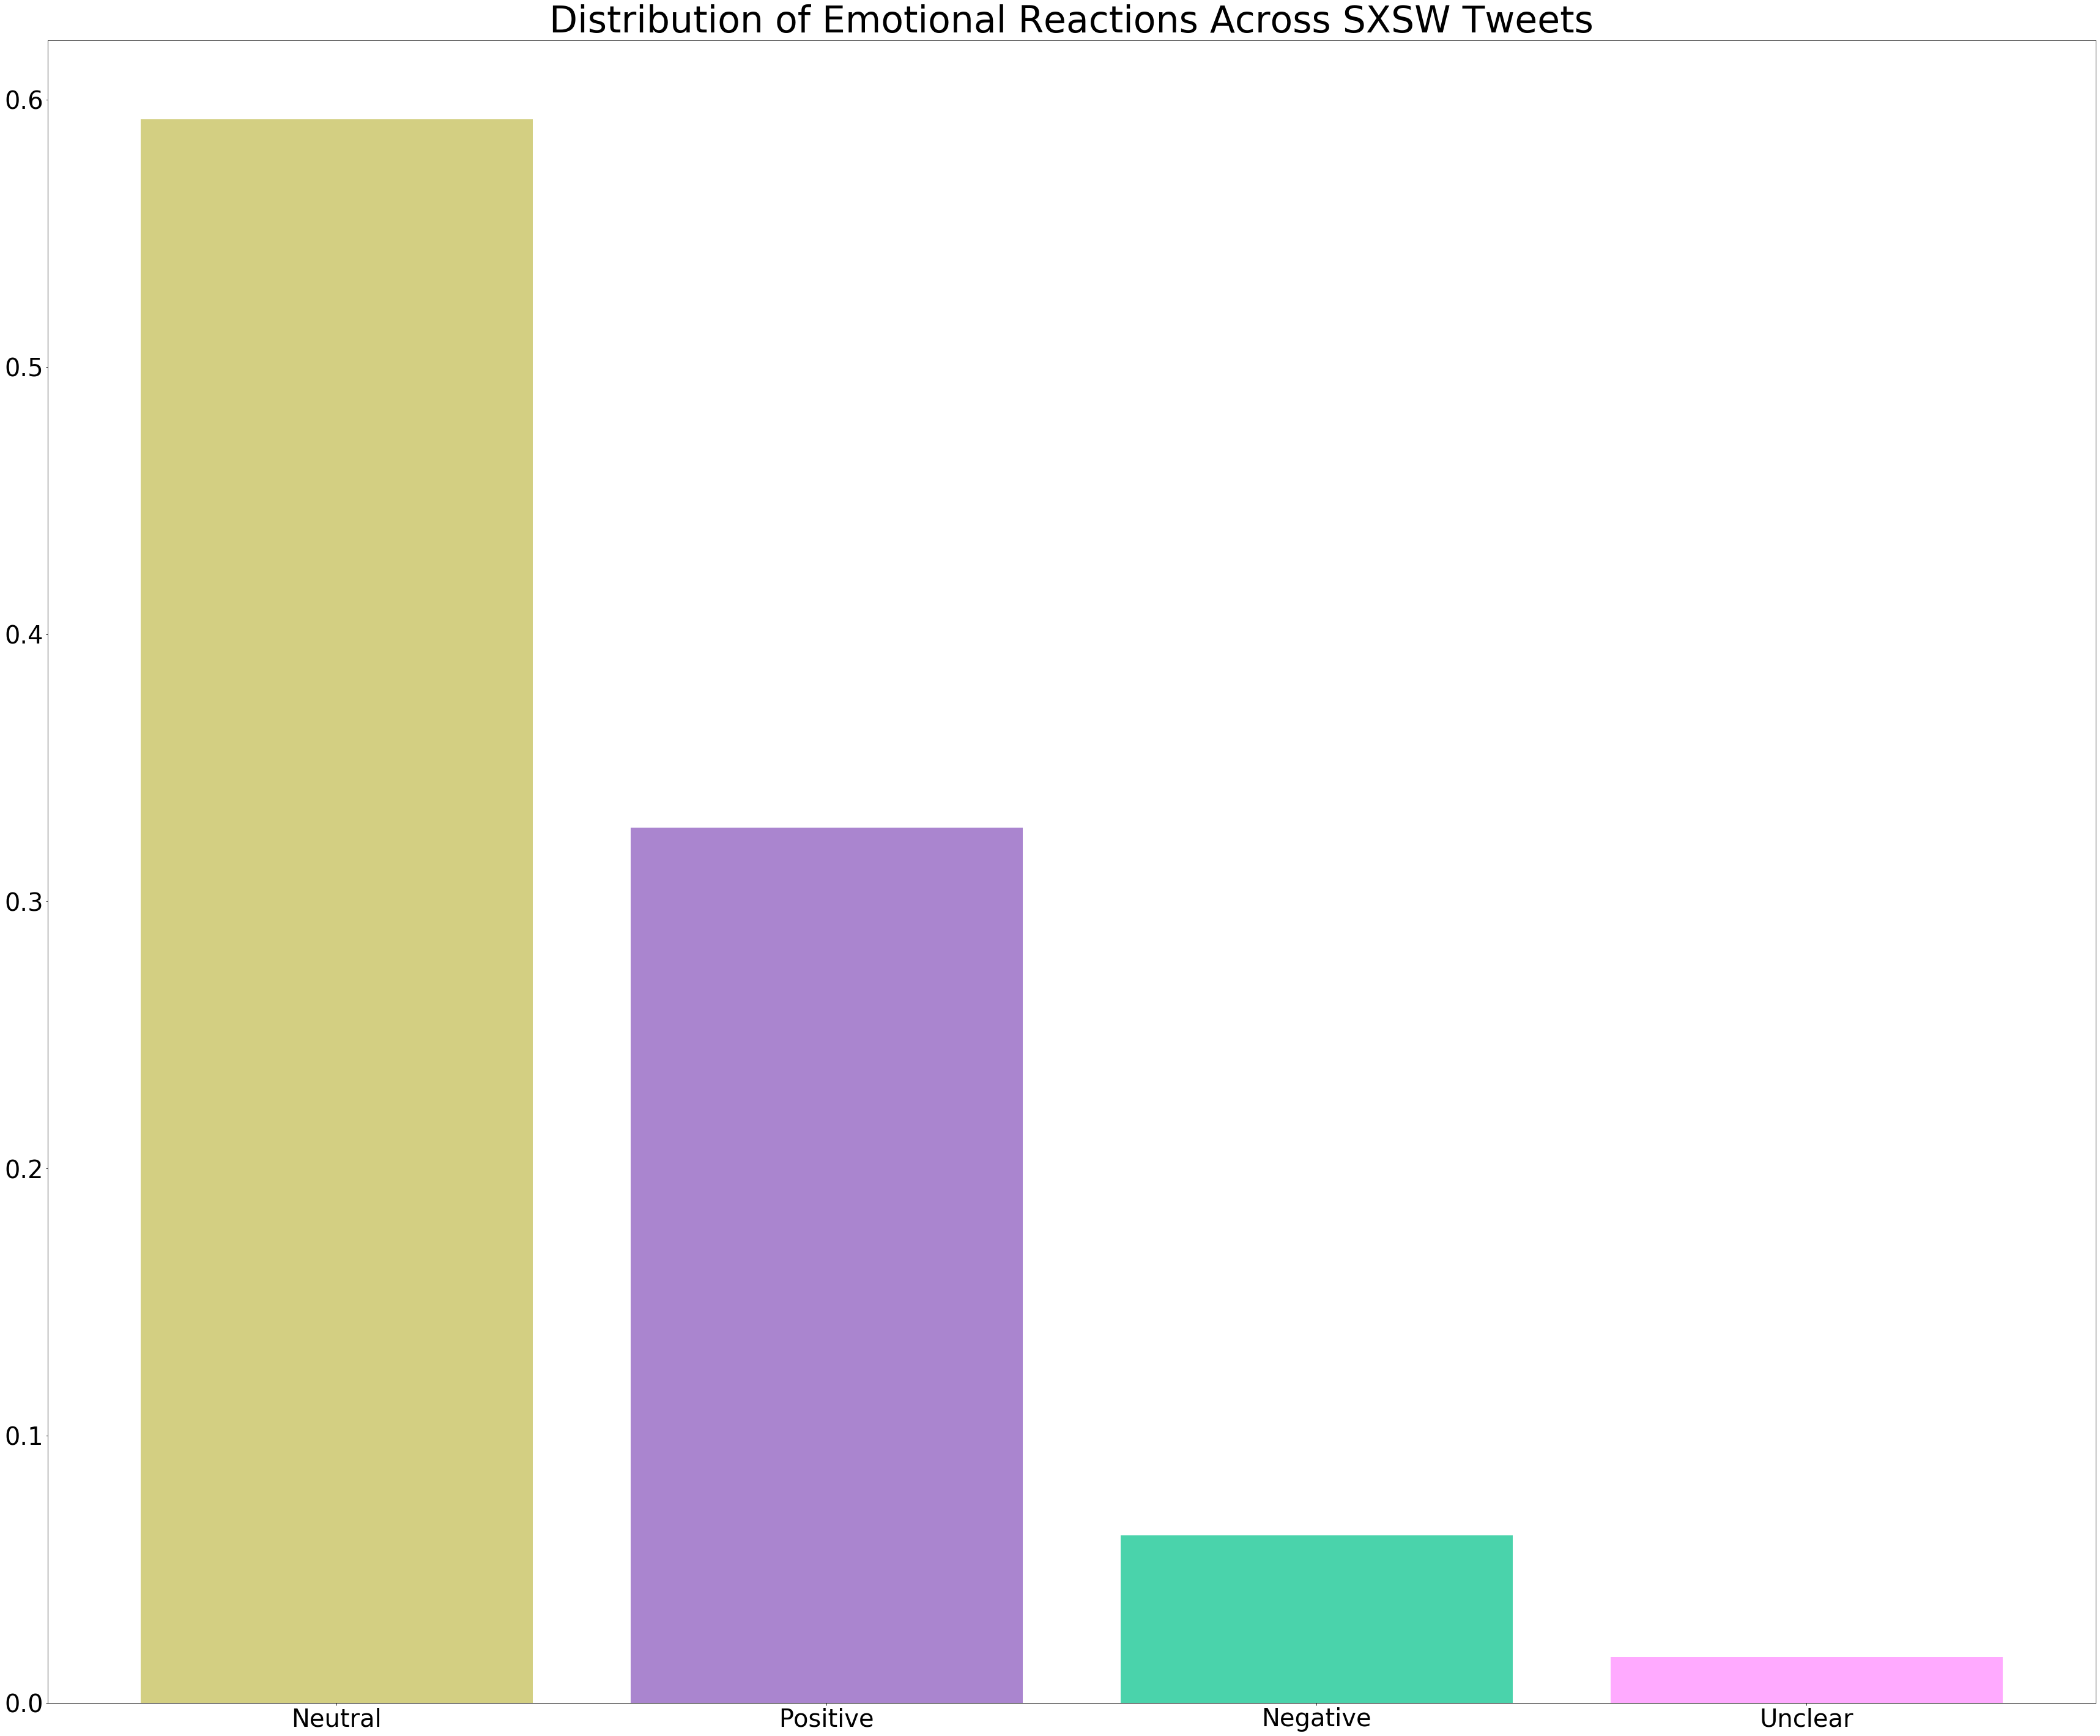

In [360]:
labels = ['Neutral', 'Positive', 'Negative', 'Unclear']
fig, ax= plt.subplots(figsize=(60,50))
ax.bar(x=range(4), height=df.target.value_counts(normalize=True), color=['#d3cf82','#aa85cf','#4ad3ab','#FFaaFF'])
ax.set_xticks(range(4))
ax.tick_params(axis='y', labelsize= 40)
ax.set_xticklabels(labels, fontsize= 40)
ax.set_title('Distribution of Emotional Reactions Across SXSW Tweets', fontsize= 60)
plt.savefig('emotiondistribution.png')

In [101]:
iphone_heights= df[((df.directed_at=='iPhone'))&((df.target==1)|(df.target==2))].groupby(df.directed_at).target.value_counts(normalize=True).loc['iPhone']
android_heights = df[((df.directed_at=='Android'))&((df.target==1)|(df.target==2))].groupby(df.directed_at).target.value_counts(normalize=True).loc['Android']

In [107]:
phone_heights = [iphone_heights[2], iphone_heights[1], android_heights[2], android_heights[1]]

In [375]:
apple_heights=df[(df.target==1)|(df.target==2)].groupby(df.brand).target.value_counts(normalize=True).loc['Apple']
google_heights=df[(df.target==1)|(df.target==2)].groupby(df.brand).target.value_counts(normalize=True).loc['Google']

In [392]:
brand_heights= [apple_heights[2], apple_heights[1], google_heights[2], google_heights[1]]

In [377]:
brand_heights

[0.8339751818570817,
 0.16602481814291828,
 0.8466042154566745,
 0.15339578454332553]

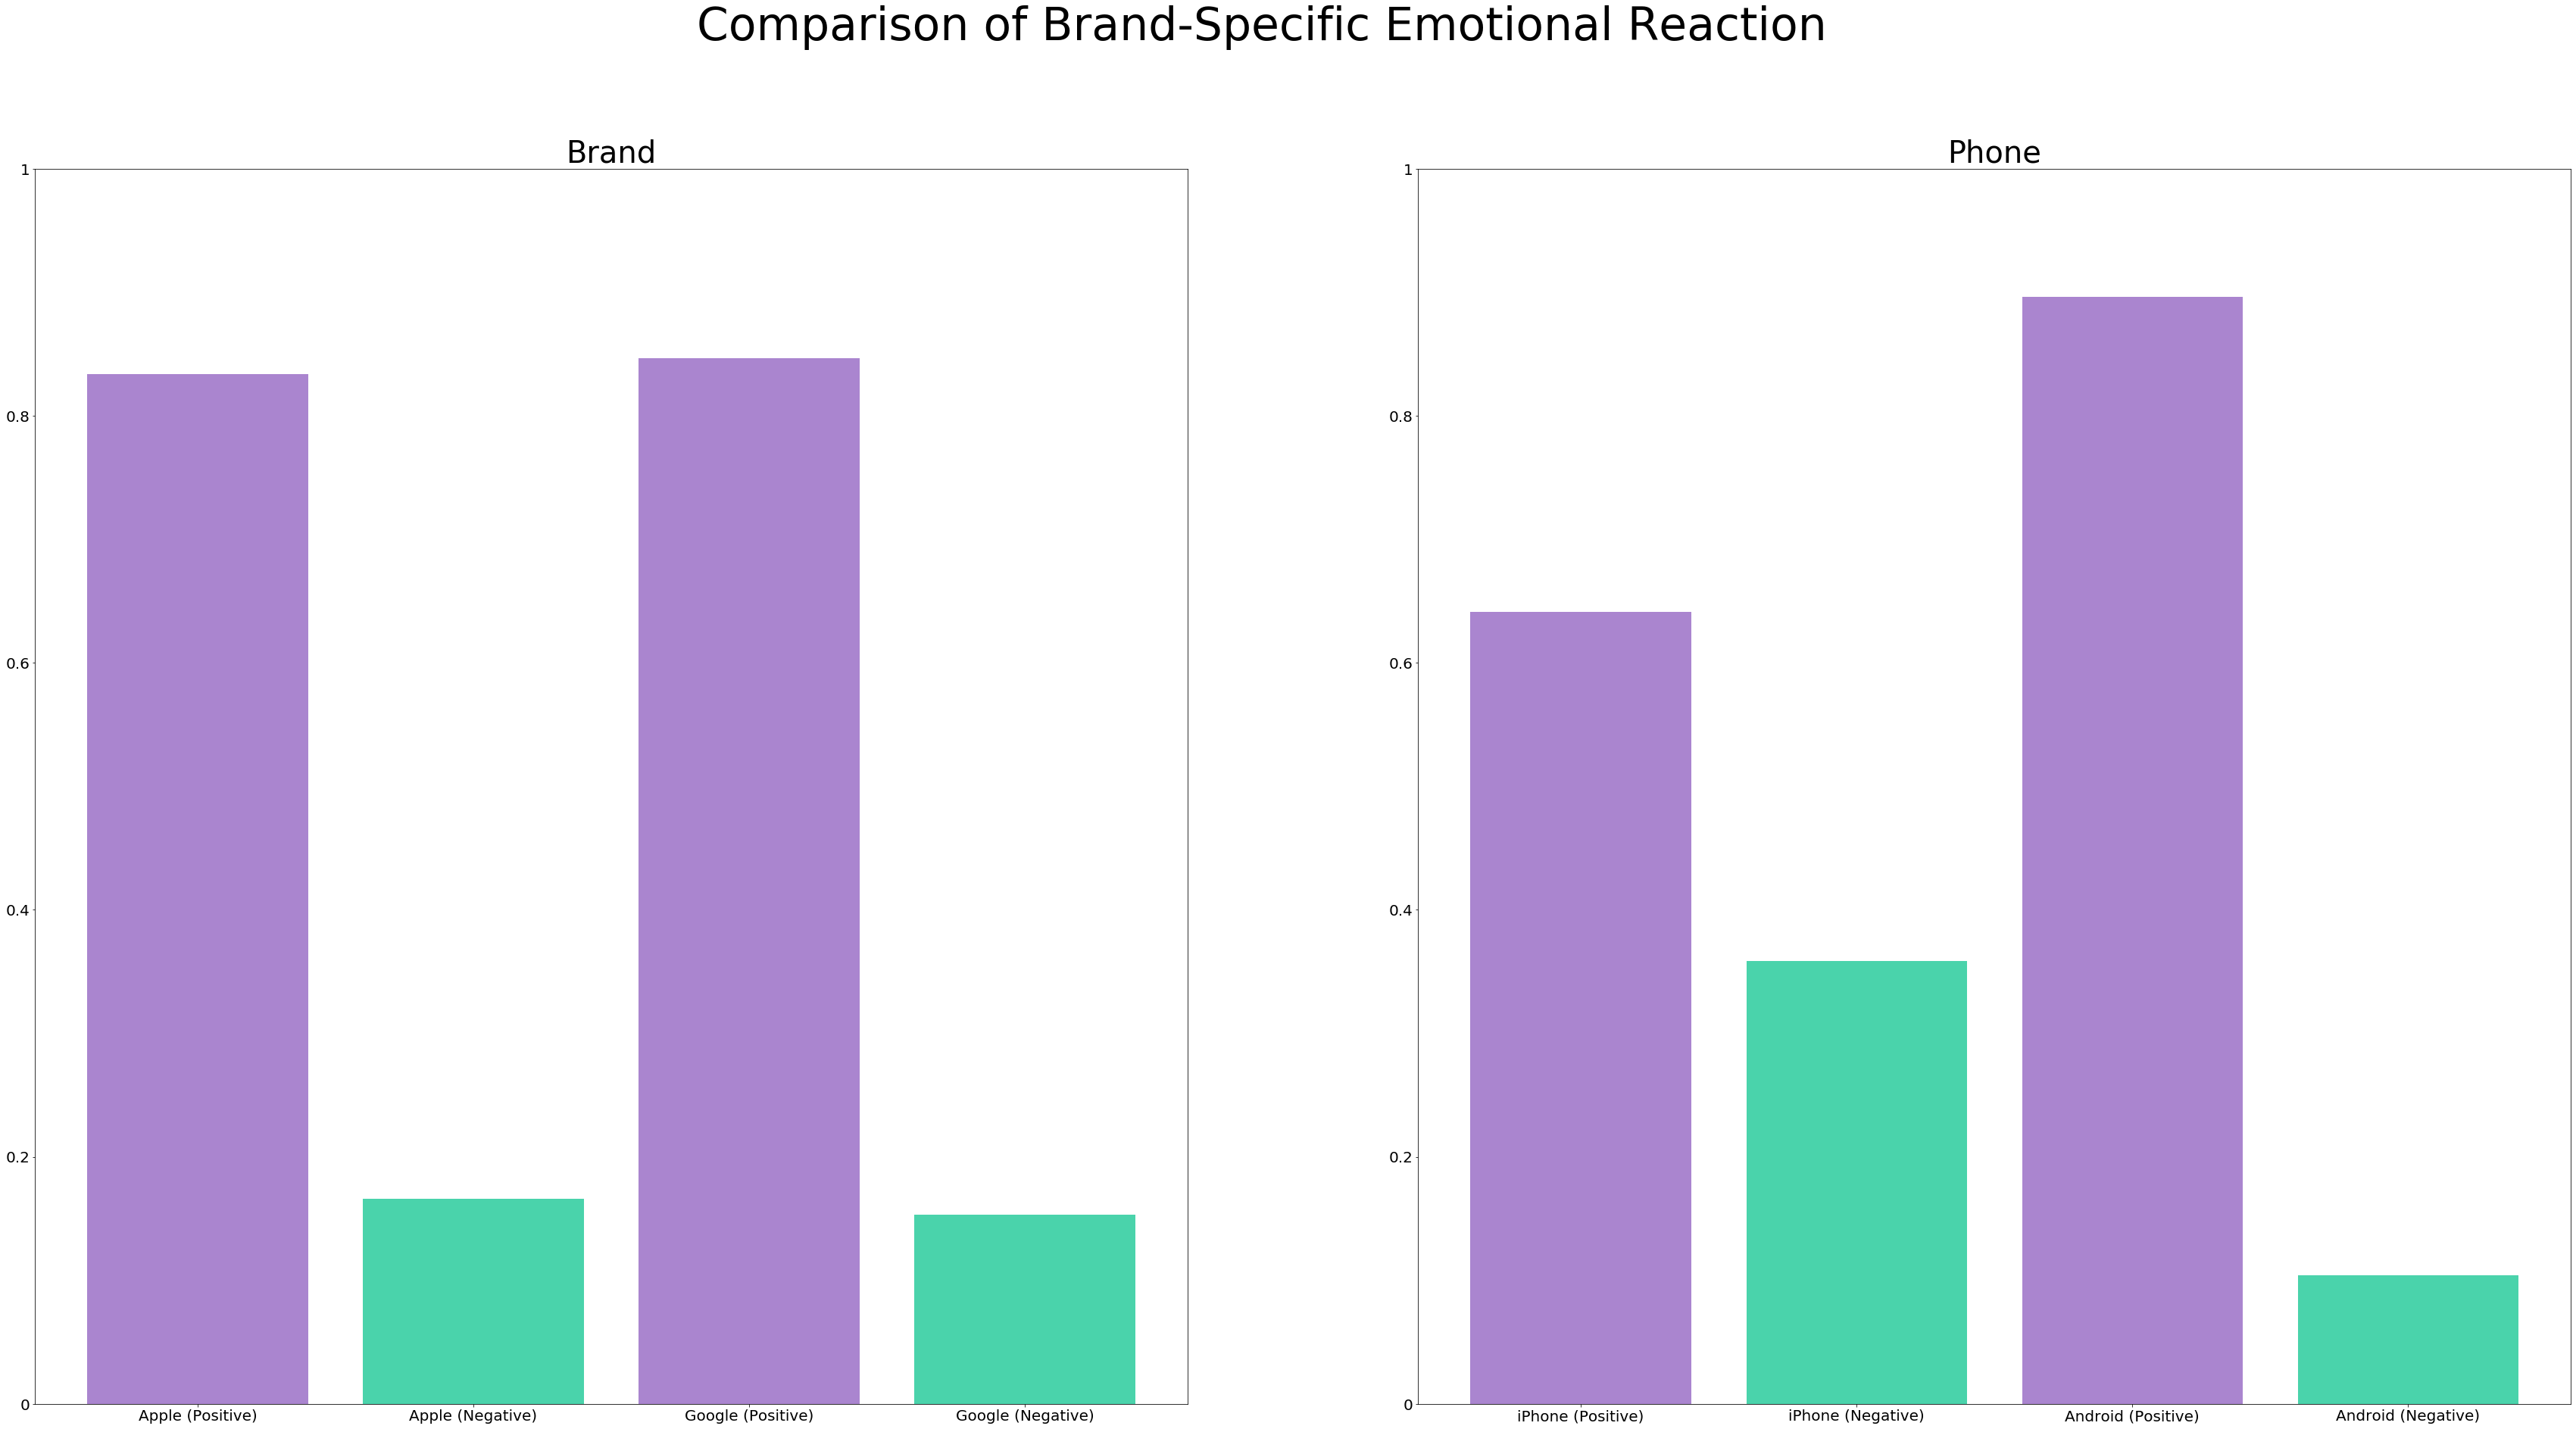

In [407]:
brand_labels=['Apple (Positive)', 'Apple (Negative)', 'Google (Positive)', 'Google (Negative)']
fig, axs = plt.subplots(1, 2, figsize=(60,30))
fig.suptitle('Comparison of Brand-Specific Emotional Reaction', fontsize= 60)

axs[0].bar(x=range(4), height=brand_heights , color=['#aa85cf','#4ad3ab'])
axs[0].set_xticks(range(4))
axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[0].set_yticklabels(labels=[0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)

axs[0].set_xticklabels(brand_labels, fontsize= 20)
axs[0].set_title('Brand', fontsize= 40)

phone_labels = ['iPhone (Positive)','iPhone (Negative)', 'Android (Positive)','Android (Negative)']
axs[1].bar(x=range(4), height= phone_heights, color=['#aa85cf','#4ad3ab'])
axs[1].set_xticks(range(4))
axs[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[1].set_yticklabels(labels=[0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
axs[1].set_xticklabels(phone_labels, fontsize= 20)

axs[1].set_title('Phone', fontsize=40)

plt.savefig('brandcomparison.png')

### EDA with Tf-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
text_tf= tf.fit_transform(df['doc'])


In [28]:
tf_df=pd.DataFrame(text_tf.todense(), columns=tf.get_feature_names())

In [32]:
tf_df['target']=df['target']

In [39]:
tf_df['brand']=df['brand']

In [83]:
tf_idf_pos = tf_df[(tf_df.target==1)].drop(["brand",'target'],axis=1)
tf_idf_neg= tf_df[(tf_df.target==0)].drop(["brand",'target'],axis=1)

tf_idf_pos_apple = tf_df[(tf_df.target==1) & (tf_df.brand=='Apple')].drop(["brand",'target'],axis=1)
tf_idf_neg_apple = tf_df[(tf_df.target==0) & (tf_df.brand=='Apple')].drop(["brand",'target'],axis=1)

tf_idf_pos_google = tf_df[(tf_df.target==1) & (tf_df.brand=='Google')].drop(["brand",'target'],axis=1)
tf_idf_neg_google = tf_df[(tf_df.target==0) & (tf_df.brand=='Google')].drop(["brand",'target'],axis=1)

In [86]:
tf_idf_pos.sum().sort_values(ascending=False)[:40]

mention      224.511734
sxsw         193.660593
link         162.527036
apple        142.798015
ipad         140.110957
rt           127.200135
store        105.167513
google       100.844504
quot          84.106635
iphone        82.813804
app           79.997179
new           67.620159
austin        64.200922
pop           53.255712
ipad2         51.657430
launch        45.885249
open          45.282172
android       44.932493
win           41.825648
amp           40.988251
line          39.219741
party         36.513045
come          35.592639
cool          34.877582
get           34.085662
great         32.178002
time          31.732782
good          31.329506
day           30.565960
social        30.322765
free          30.304184
love          30.232420
temporary     30.103913
today         28.830810
downtown      28.309631
awesome       27.942313
check         27.771641
like          27.202642
go            26.477913
sxswi         26.115112
dtype: float64

In [88]:
tf_idf_neg.sum().sort_values(ascending=False)[:40]

sxsw        33.309138
mention     28.898188
quot        28.640779
iphone      24.318413
ipad        24.270114
google      19.590876
rt          16.827898
apple       15.961096
app         15.450086
link        12.956440
like         9.306551
design       9.001104
store        8.184329
need         7.884855
new          7.729177
social       7.673989
people       7.585123
think        7.199903
circles      7.025353
launch       6.994233
fail         6.667648
long         6.483199
look         6.379914
battery      6.271350
headache     5.896996
line         5.737410
android      5.479356
news         5.391246
time         5.339933
fascist      5.029461
today        4.994361
come         4.936545
america      4.928237
day          4.881867
austin       4.869708
money        4.822884
talk         4.782872
company      4.748838
pop          4.695831
phone        4.628119
dtype: float64

In [90]:
pos_terms = list(tf_idf_pos.sum().sort_values(ascending=False)[:1000].index)
neg_terms= list(tf_idf_neg.sum().sort_values(ascending=False)[:1000].index)
common_features = [term for term in pos_terms if term in neg_terms]
common_features[:10]

['mention',
 'sxsw',
 'link',
 'apple',
 'ipad',
 'rt',
 'store',
 'google',
 'quot',
 'iphone']

In [91]:
len(common_features)

422

In [ ]:
df

In [72]:
tf_idf_pos_apple.max().sort_values(ascending=False)[:40]

tempt          0.956088
heart          0.915550
congrats       0.910311
wish           0.905429
rock           0.892308
pick           0.890417
covet          0.885907
giveaway       0.879995
oh             0.866807
hipstamatic    0.839240
zomg           0.836724
periscope      0.828499
joke           0.826003
blackberry     0.822718
depressed      0.822363
exquisite      0.818384
hollrback      0.813522
plane          0.812825
denote         0.809943
truck          0.801934
reason         0.794659
retweet        0.792893
groove         0.788816
short          0.786381
comer          0.783179
checkin        0.776913
squeal         0.771193
aapl           0.769275
take           0.765545
fxsw           0.761995
domo           0.761672
course         0.752375
suffer         0.751943
piss           0.750462
channel        0.744708
jealous        0.742894
battlela       0.741003
sale           0.739540
softlayer      0.738480
austincrowd    0.737955
dtype: float64

In [71]:
tf_idf_neg_apple.max().sort_values(ascending=False)[:40]

mad                 0.886900
battery             0.870707
delete              0.847368
quot                0.827184
pop                 0.816352
glad                0.784463
shame               0.765821
abacus              0.758276
magic               0.757121
ridic               0.755594
sigh                0.752624
dangerous           0.725249
smcomedyfyeah       0.694250
idiot               0.694250
stress              0.688579
wilt                0.688579
boo                 0.680610
autocorrect         0.679454
conflagration       0.664624
doofusness          0.664624
shit                0.663018
suck                0.661513
embarrassed         0.660133
betterthingstodo    0.655770
precommerce         0.654577
rear                0.648288
douchebag           0.634334
headache            0.629028
mock                0.625632
usage               0.623180
news                0.621446
sustainability      0.614131
blur                0.611406
srsly               0.608826
year          

In [84]:
tf_idf_pos_google.max().sort_values(ascending=False)[:40]

orly             0.856847
pi               0.851599
rocks            0.850580
whoooooo         0.839803
anxious          0.827014
proud            0.808192
tshirt           0.780688
gt               0.750793
party            0.748174
bread            0.734646
people           0.734305
wowwwwww         0.726202
pdanet           0.725810
arrive           0.720615
domo             0.720507
suckas           0.718473
butt             0.714037
group            0.711303
syke             0.706071
check            0.700733
calyp            0.696055
marcelosomers    0.695678
hook             0.682226
offer            0.678742
awesome          0.676773
realtime         0.675339
soundcloud       0.665674
lose             0.657568
157              0.654464
block            0.654299
view512          0.654060
winning          0.652104
quot             0.651982
android          0.645695
tooth            0.645610
grindr           0.639157
useful           0.639019
survive          0.636535
true        

In [82]:
tf_idf_neg_google.sum().sort_values(ascending=False)[:40]

google       16.539695
mention       7.968708
quot          7.261575
sxsw          7.210344
social        5.705674
circles       5.452110
rt            5.294677
launch        4.782695
android       3.722686
link          3.312102
today         3.186554
product       3.179859
network       3.144058
new           2.921480
service       2.607064
bing          2.593906
need          2.569421
major         2.384683
fail          2.358433
mayer         2.327612
care          2.268219
app           2.014567
solution      2.002699
business      1.984743
vs            1.972296
lose          1.919931
not           1.893292
technical     1.873186
tv            1.816360
call          1.796950
way           1.770431
user          1.764733
tag           1.597295
suck          1.571639
think         1.543316
possibly      1.508791
time          1.468665
comment       1.424555
circle        1.393609
room          1.381906
dtype: float64